In [1]:
import mysql.connector
import tensorflow as tf
import keras
import numpy as np
import datetime 
from datetime import datetime

import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

In [2]:
class Database:

    def __init__(self, hostname, username, password):

        self.host = hostname
        self.user = username
        self.password = password

    def connect_server(self):
        mydb = mysql.connector.connect( host = self.host,
                                        user = self.user,
                                        passwd = self.password,
                                        )
        return mydb

    def connect_db(self, dbname):
        mydb = mysql.connector.connect( host = self.host,
                                        user = self.user,
                                        passwd = self.password,
                                        database = dbname
                                        )
        return mydb

    

    def create_db(self, name):
        connection = Database.connect_db(self)
        cursor = connection.cursor()
        
        cursor.execute(f"CREATE DATABASE {name}")
        print('Database Created successfully')

    def create_table(self, name, features, database):

        self.database = database
        connection = Database.connect_db(self)
        cursor = connection.cursor()
        cursor.execute(f"CREATE TABLE {name} {features}")
        print('Table created succeccfully')

In [3]:
class worker():


    def __init__(self, new_connection, cursor, model, classifier):
        #super().__init__(model)
        
        self.new_connection = new_connection
        self.cursor = cursor

        self.img = self.image(model, classifier)


    class image:
     
        def __init__(self, model, classifier):
            self.model = model
            self.classifier = classifier


        def add_img_data(self, id, arr, dbname = "Image-Database"):

            current_path = os.getcwd()
            path = current_path + '/' + dbname
            if not os.path.exists(path):
                os.mkdir(path)

            filename = f"{id}.npy"
            np.save(os.path.join(path,filename),arr)
            return ("Image successfully added")

        def image(self):
            try:
                    
                frame = self.capture()
                faces = self.update(frame)[0]
                print(faces)
                x1, y1, width, height = faces[0] - 40, faces[1]  - 100, faces[2] + 80, faces[3] + 110
                x2, y2 = x1 + width, y1 + height
                face = frame[y1:y2, x1:x2]
                img = Image.fromarray(face)
                img = np.array(img)
                arr = self.img_to_encoding(img)
                return arr
            except:
                print("face not captured")
                arr = self.image()
                return arr

        def img_to_encoding(self, img):
            img = cv2.resize(img, (160, 160))
            img = np.around(np.array(img) / 255.0, decimals=12)
            x_train = np.expand_dims(img, axis=0)
            embedding = self.model.predict_on_batch(x_train)
            return embedding / np.linalg.norm(embedding, ord=2)

        def directory_img_encoding(self,image_path):
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
            img = np.around(np.array(img) / 255.0, decimals=12)
            x_train = np.expand_dims(img, axis=0)
            embedding = self.model.predict_on_batch(x_train)
            return embedding / np.linalg.norm(embedding, ord=2)

        def isGray(self, image):
            """Return True if the image has one channel per pixel."""
            return image.ndim < 3

        def update(self, image):
            """Update the tracked facial features."""
            
            if self.isGray(image):
                image = cv2.equalizeHist(image)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                cv2.equalizeHist(image, image)
            
            faceRects = self.classifier.detectMultiScale(
                image, 1.2, 2, cv2.CASCADE_SCALE_IMAGE)

            return faceRects
        
        def capture(self):
            vid = cv2.VideoCapture(0)
            
            while(True):
            
                ret, frame = vid.read()
                (h, w) = frame.shape[:2]
                axesLength = (200, 150)
                angle = 90
                startAngle = 0
                endAngle = 360
                # Red color in BGR
                color = (0, 0, 155)
                # Line thickness of 5 px
                thickness = 5
                cv2.ellipse(frame,(w//2, h//2) , axesLength,
                            angle, startAngle, endAngle, color,
                            thickness,lineType= cv2.LINE_AA)
                cv2.imshow('frame', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            vid.release()
            cv2.destroyAllWindows()
            return frame

        def extract(self, frame):
            
            detector = MTCNN()
            results = detector.detect_faces(frame)
            x1, y1, width, height = results[0]['box']
            # bug fix
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            # extract the face
            face = frame[y1:y2, x1:x2]
            # resize pixels to the model size
            image = Image.fromarray(face)
            image = image.resize((160,160))
            return image



    def register_worker(self):

        try:
            id = int(input('Enter a new id: '))
            self.cursor.execute("select id from workers_info")
            workers_id = self.cursor.fetchall()
            workers_id = [x[0] for x in workers_id]

            if (id in workers_id):
                return ("Id exist in database")

            name = str(input('Enter your name: '))
            gender = input('What is your gender: ')
            address = input('Enter you address: ')
            position = input('What is your position in the company')
            employment_date = input("Enter your employment date: ")
            resumption_date = input("Enter your resumption date: ")
            salary_per_hr = input('Enter worker hourly pay: ')
            daily_work_hrs = input('Enter work total work hours per day: ')

          
            arr = self.img.image()
            img = self.img.add_img_data(id, arr)
        

            record = (id, name, gender, address, position, employment_date,
                            resumption_date, salary_per_hr, daily_work_hrs)
            self.cursor.execute(f"insert into workers_info\
                            values{record}")
            self.new_connection.commit()
            print("Successully added the worker's record")
        except:
            print('Incorrect input given')

    def retrieve_img_encoding(self, id, dbname = "Image-Database"):
        path = os.getcwd()
        db_path = os.path.join(path, dbname)
        enc = np.load(os.path.join(db_path, f"{id}.npy"))
        return enc

    def sign_in(self):
    
        id = int(input('Enter your id: '))
        validation = self.worker_val('workers_info', id)

        if validation =='pass':

            date = datetime.today().strftime('%Y-%m-%d')
            self.cursor.execute(f"select id from register \
                                where date = {date}")
            workers_id = self.cursor.fetchall()
            workers_id = [x[0] for x in workers_id]

            if (id in workers_id):
                return ("worker signed in already")

            self.cursor.execute(f"select name from workers_info\
                                        where id = {id}")
            name = self.cursor.fetchone()[0]
            

            frame = self.img.capture()
            # faces = self.img.update(frame)[0]

            # x1, y1, width, height = faces[0] - 80, faces[1]  - 80, faces[2] + 80, faces[3] + 80
            # x2, y2 = x1 + width, y1 + height
            # # extract the face
            # face = frame[y1:y2, x1:x2]
            # # resize pixels to the model size
            # img = Image.fromarray(face)
            # #img = extract(frame)
            img = np.asarray(frame)
            plt.imshow(img)

            enc = self.retrieve_img_encoding(id)
            
            real_worker = self.verify(img, name, enc)

            if real_worker == True:
            
                time_in =  datetime.today().strftime('%H:%M')
                time_out = datetime.today().strftime('%H:%M')

                record = (id, date, name, time_in, time_out)
                self.cursor.execute(f"insert into register \
                            values{record}")

                self.new_connection.commit()
                print("Sign in Successully")

        else:
            print('Individual recod not in database')


    

    def worker_val(self, dbname, id):

        self.cursor.execute(f"select * from {dbname}")
        myresult = self.cursor.fetchall()
        workers_id = [x[0] for x in myresult]
        if id in workers_id:
            return ('pass')
        else:
            reg = input('Will the worker be registered: ')
            reg = reg.lower()

            if reg=='yes':
                new_input = self.register_worker()
            else:
                print('Individual not in company database')

    def signin_val(self, dbname, id):

        date = datetime.today().strftime('%Y-%m-%d')
        self.cursor.execute(f"select * from {dbname} where date = '{date}'")
        myresult = self.cursor.fetchall()
        workers_id = [x[0] for x in myresult]

        if id in workers_id:
            return ('pass')
        
        else:
            print('Individual did not sign in today')

    def sign_out(self):

        id = int(input('Enter your id: '))
        clock_out = self.signin_val('register', id)

        if clock_out=='pass':

            #name = str(input('Enter your name: '))
            self.cursor.execute(f"select name from register\
                                        where id = {id}")

            name = self.cursor.fetchone()[0]
            frame = self.img.capture()
            #img = extract(frame)
            img = np.asarray(frame)
            plt.imshow(img)

            enc = self.retrieve_img_encoding(id)
            
            real_worker = self.verify(img, name, enc)

            if real_worker == True:
                    
                time = datetime.now().strftime('%H:%M')
                query = f"update register set \
                            time_out = '{time}' \
                            where id = {id}"
                self.cursor.execute(query)
                self.new_connection.commit()
                print("Successully updated the record")


    def verify(self, img, identity, enc):

        encoding = self.img.img_to_encoding(img)
        dist = np.linalg.norm(enc -  encoding)
        if dist < 0.7:
            return True
        else:
            return False

In [4]:
host_name = 'localhost'
user_name = 'root'
password = 'Pattern'
database_name =  'GraceTouch'

db = Database(host_name, user_name, password)
#db.connect_server()



# workers_info = "(id int not null, name varchar(50), gender char(1), address varchar(30),\
#                 position varchar(10), employment_date date, resumption_date date,\
#                 salary_per_hr float, daily_work_hrs int, primary key (id))"
# db.create_table(name = 'workers_info', features = workers_info, database = 'gracetouch')


# company_register = "(id int not null, date date, name varchar(50), \
#                      time_in time, time_out time, primary key (id))"
# db.create_table(name = 'register', features = company_register, database = 'gracetouch')

new_connection = db.connect_db(database_name)
cursor = new_connection.cursor(buffered=True)

In [5]:
frmodel = keras.models.load_model('./converted.h5')
classifier = cv2.CascadeClassifier(
           "C:/Users/Godwin/Documents/Workflow/opencv/chapter3/3923_04/cameo/cascades/haarcascade_frontalface_alt.xml")
woker_cls = worker(new_connection,cursor,frmodel, classifier)

c:\Users\Godwin\.conda\envs\Tensorflow\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: inception_resnet_v1 is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


Successully updated the record


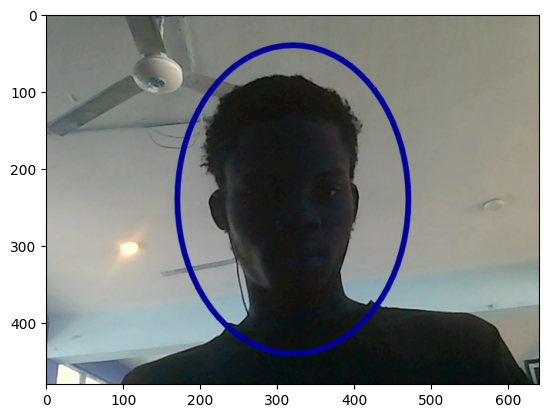

In [6]:
woker_cls.sign_out()